# Energy and emissions

This notebook aims to show the link (if not causal relationship) between energy consumption (or production) and **Greenhouse Gas** (GHG) emissions.

This notebook is coded in Python and relies on a few libraries (or packages), which we load below.


In [253]:
import pandas as pd                      # This library is for data wrangling
import seaborn as sns                    # This is one library for plotting
import matplotlib.pyplot as plt          # Yet another library for visualization
import plotly.express as px              # This is another library for plots 
import requests
import json
from zipfile import ZipFile
from io import BytesIO
import warnings                          # This is to remove warning to keep output clean
warnings.filterwarnings('ignore')

## Emissions data: long-term perspective


We will resort to two datasets for emissions: one for a dynamic analysis on GHG and one for a cross-sectional study on carbon emissions only.  
As we will see, depending on the source, the results may substantiallt change.  
We obtain the first one from the website https://resourcewatch.org/data/explore/cli008-Greenhouse-Gas-Emissions-by-Country-and-Sector-Full-Longform. 
The data comes from the Climate Analysis Indicators Tools (CAIT) Climate Data Explorer.



In [254]:
url = 'https://wri-public-data.s3.amazonaws.com/resourcewatch/cli_008_greenhouse_gas_emissions_country_sector.zip'
filename = requests.get(url).content
zf = ZipFile( BytesIO(filename), 'r')
zf.getinfo('historical_emissions.zip')
zf = ZipFile(zf.open('historical_emissions.zip'))

data_ghg = pd.read_csv(zf.open('historical_emissions.csv'))
data_ghg

,Country,Data source,Sector,Gas,Unit,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,World,CAIT,Total including LUCF,All GHG,MtCO₂e,48939.71,47990.47,47413.95,46760.47,46647.29,46047.13,45427.61,44891.40,44758.58,43029.01,43003.97,42644.63,41831.65,40300.03,39437.14,37618.01,36727.84,35701.77,35607.73,34948.94,34929.19,35387.89,34068.91,33703.46,32977.47,32766.49,32670.32,32813.46,32645.91
1,World,CAIT,Total excluding LUCF,All GHG,MtCO₂e,47552.14,46770.42,46146.35,45974.01,45909.35,45658.86,44994.97,44486.72,43268.37,41203.89,41571.04,41172.98,39826.52,38668.69,37527.82,36072.46,34874.73,34363.55,33936.77,33129.09,32918.04,32706.56,32357.54,31788.31,31068.15,30857.21,30761.03,30904.18,30736.62
2,World,CAIT,Energy,All GHG,MtCO₂e,37224.95,36539.61,36080.14,36060.24,36053.93,35997.40,35390.08,34998.41,34064.92,32205.11,32624.44,32287.22,31158.63,30201.08,29169.44,27915.32,26782.94,26392.45,25987.41,25236.65,25085.99,24925.72,24544.78,24048.52,23464.22,23432.23,23345.54,23506.23,23363.95
3,World,CAIT,Electricity/Heat,All GHG,MtCO₂e,15590.95,15167.36,14949.51,15009.83,15232.52,15320.55,15059.19,14755.36,14151.17,13257.85,13457.77,13427.33,12861.97,12373.25,12001.49,11617.71,10999.87,10813.15,10552.87,10134.66,10080.66,9853.19,9586.39,9231.22,9042.50,8945.80,8894.60,8735.04,8596.17
4,China,CAIT,Total excluding LUCF,All GHG,MtCO₂e,12355.24,12058.05,11857.18,11859.29,11865.31,11854.53,11399.83,11074.55,10203.82,9377.66,8786.12,8497.04,7879.33,7194.48,6467.06,5717.66,5100.86,4791.44,4597.43,4401.29,4451.04,4311.65,4302.87,4266.84,3877.37,3726.35,3503.10,3371.94,3222.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,Tonga,CAIT,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2704,Uganda,CAIT,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2705,Saint Vincent and the Grenadines,CAIT,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2706,Vanuatu,CAIT,Fugitive Emissions,All GHG,MtCO₂e,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


All units are in equivalents of CO_2 metric tons, so we can remove the column. Same for the data source, which is not useful for us now - as well as for "Gas".  
We need to reshape the data to a 'long' format.

In [255]:
data_ghg = data_ghg.drop(labels = ['Unit', 'Data source', 'Gas'], axis=1)
data_ghg = pd.wide_to_long(data_ghg, 
                stubnames = [''], 
                i = ['Country', 'Sector'],
                j = 'Year').reset_index()
data_ghg = data_ghg.rename(columns = {"": "Emissions"})
data_ghg

,Country,Sector,Year,Emissions
0,World,Total including LUCF,2018,48939.71
1,World,Total including LUCF,2017,47990.47
2,World,Total including LUCF,2016,47413.95
3,World,Total including LUCF,2015,46760.47
4,World,Total including LUCF,2014,46647.29
...,...,...,...,...
78527,Samoa,Fugitive Emissions,1994,0.00
78528,Samoa,Fugitive Emissions,1993,0.00
78529,Samoa,Fugitive Emissions,1992,0.00
78530,Samoa,Fugitive Emissions,1991,0.00


Let's see which are the sector categories.

In [256]:
data_ghg.Sector.unique()

array(['Total including LUCF', 'Total excluding LUCF', 'Energy',
       'Electricity/Heat', 'Transportation', 'Manufacturing/Construction',
       'Agriculture', 'Industrial Processes', 'Fugitive Emissions',
       'Building', 'Waste', 'Other Fuel Combustion',
       'Land-Use Change and Forestry', 'Bunker Fuels'], dtype=object)

That's a lot! Let's see the dynamic.

In [257]:
data_ghg_global_plot = data_ghg.query('Sector != "Total including LUCF"').query('Sector != "Total excluding LUCF"')
data_ghg_global_plot = data_ghg_global_plot.drop_duplicates(subset = ['Year', 'Sector'])
data_ghg_global_plot = data_ghg_global_plot.pivot(index = ['Year'], 
                                                  columns = 'Sector', 
                                                  values = "Emissions").reset_index()
data_ghg_global_plot

Sector,Year,Agriculture,Building,Bunker Fuels,Electricity/Heat,Energy,Fugitive Emissions,Industrial Processes,Land-Use Change and Forestry,Manufacturing/Construction,Other Fuel Combustion,Transportation,Waste
0,1990,4997.83,2596.85,630.86,8596.17,23363.95,2253.38,1010.44,1909.29,3955.39,1353.12,4609.04,1364.40
1,1991,4988.46,2622.04,638.25,8735.04,23506.23,2261.86,1014.31,1909.29,3875.91,1362.83,4648.55,1395.18
2,1992,4966.82,2514.52,675.22,8894.60,23345.54,2165.36,1030.40,1909.29,3743.48,1274.10,4753.49,1418.28
3,1993,4936.15,2574.50,667.47,8945.80,23432.23,2129.69,1044.44,1909.29,3694.80,1293.13,4794.31,1444.39
4,1994,4981.35,2492.94,693.78,9042.50,23464.22,2063.05,1151.62,1909.32,3711.41,1262.92,4891.40,1470.96
5,1995,5038.18,2566.84,717.67,9231.22,24048.52,2073.70,1225.10,1915.15,3937.60,1214.26,5024.90,1476.51
6,1996,5057.35,2637.75,739.58,9586.39,24544.78,2106.34,1277.11,1711.37,3827.31,1154.63,5232.37,1478.31
7,1997,4986.72,2615.10,765.10,9853.19,24925.72,2091.65,1319.75,2681.33,3852.36,1203.74,5309.68,1474.36
8,1998,5042.29,2463.09,789.13,10080.66,25085.99,2076.10,1323.48,2011.15,3854.06,1180.80,5431.29,1466.28
9,1999,5098.82,2533.91,830.32,10134.66,25236.65,2089.09,1329.14,1819.85,3694.74,1191.82,5592.43,1464.47


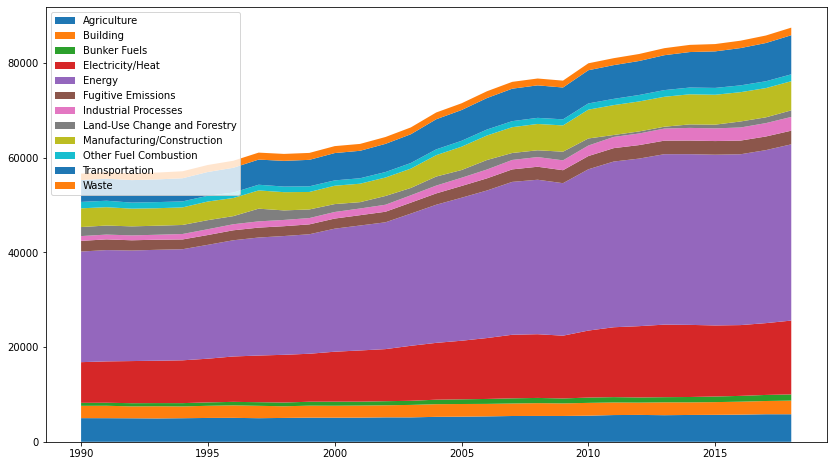

In [258]:
plt.stackplot(data_ghg_global_plot['Year'],
              data_ghg_global_plot.drop('Year', axis = 1).to_numpy().transpose(),
              labels = list(data_ghg_global_plot.drop('Year', axis = 1).columns))
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"]=(14, 8)
plt.show()

##  Recent high frequency data
Our second source for emissions comes from Carbon Monitor: https://carbonmonitor.org. 
The website samples emissions at the daily frequency!

In [259]:
url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'
data_carbon = pd.read_csv(url, skiprows = 0)
data_carbon['date'] = pd.to_datetime(data_carbon['date'],format='%d/%m/%Y') # Correct date format
# Below, we switch to capital letters for 1st character of column names
data_carbon = data_carbon.rename(columns={'country': 'Country', 
                                          'date': 'Date', 
                                          'sector': 'Sector', 
                                          'value': 'Value', 
                                          'timestamp': 'Timestamp'})
data_carbon

,Country,Date,Sector,Value,Timestamp
0,Brazil,2019-01-01,Power,0.108768,1546272000
1,China,2019-01-01,Power,14.251000,1546272000
2,EU27 & UK,2019-01-01,Power,1.676920,1546272000
3,France,2019-01-01,Power,0.049075,1546272000
4,Germany,2019-01-01,Power,0.349691,1546272000
...,...,...,...,...,...
76603,Russia,2021-06-30,International Aviation,0.020850,1624982400
76604,Spain,2021-06-30,International Aviation,0.028848,1624982400
76605,UK,2021-06-30,International Aviation,0.028976,1624982400
76606,US,2021-06-30,International Aviation,0.140004,1624982400


**NOTE**: the data starts in 2019 "only". We leave it aside for now

## Energy data

For **energy** production and consumption, we use data compiled by **BP**. While it is undeniably a corporate source, it is widely considered as reliable, especially for non renewable energies. For renewables, the post https://www.resilience.org/stories/2017-08-02/how-bp-is-minimizing-renewable-energy-in-its-statistical-review/ contends that the company purposefully minimizes the numbers. For our study, this will not be a major issue.

In [260]:
url = 'https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/bp-stats-review-2021-consolidated-dataset-narrow-format.xlsx'
data_energy_sources = pd.read_excel(url) # Reads the online file 
data_energy_sources                      # Shows the result

,Country,Year,ISO3166_alpha3,ISO3166_numeric,Region,SubRegion,OPEC,EU,OECD,CIS,Var,Value
0,Algeria,1965,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
1,Algeria,1966,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
2,Algeria,1967,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
3,Algeria,1968,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
4,Algeria,1969,DZA,12.0,Africa,Northern Africa,1.0,0.0,0.0,0.0,wind_twh,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
252911,Zimbabwe,2016,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.030338
252912,Zimbabwe,2017,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.236599
252913,Zimbabwe,2018,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.438812
252914,Zimbabwe,2019,ZWE,716.0,Africa,Eastern Africa,0.0,0.0,0.0,0.0,pop,14.645473


We see that the suffixes tell the units in which the values are expressed. For instance, "ej" refers to **exajoule**, which is 10^18 joules while "pt" to **petajoule**, which is 10^15 joules. The joule is a classical unit used to quantify amounts of energy.  
For obvious **consistency** reasons, we need to put all joule type units at the same scale, which we choose to be the petajoule. Hence, we need to multiply the exajoule values by 1,000.

In [261]:
data_energy_sources = data_energy_sources[data_energy_sources['Var'].str.endswith('j')]
data_energy_sources['Scale'] = data_energy_sources['Var'].transform(lambda x: 1000 if x.endswith('ej') else 1) # Scale column  
data_energy_sources['Value'] = data_energy_sources['Value'] * data_energy_sources['Scale']                     # Adjusted value
data_energy_sources = data_energy_sources.loc[:, ['Country', 'Year', 'Region', 'Var', 'Value']]                # Keeping 5 columns
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_ej'))            # Remove suffix
data_energy_sources['Var'] = data_energy_sources['Var'].map(lambda x: x.lstrip('+-').rstrip('_pj'))            # Remove suffix
data_energy_sources = data_energy_sources.rename(columns = {'Value' : 'Consumption'})                          # Change name of column
data_energy_sources

,Country,Year,Region,Var,Consumption
10006,Algeria,1965,Africa,wind,0.000000
10007,Algeria,1966,Africa,wind,0.000000
10008,Algeria,1967,Africa,wind,0.000000
10009,Algeria,1968,Africa,wind,0.000000
10010,Algeria,1969,Africa,wind,0.000000
...,...,...,...,...,...
245378,US,2016,North America,biodiesel_cons,259.853847
245379,US,2017,North America,biodiesel_cons,247.374569
245380,US,2018,North America,biodiesel_cons,237.209821
245381,US,2019,North America,biodiesel_cons,225.887978
